---
title: "The Condorcet Jury Theorem and Democratic Rationality"
subtitle: "Sensitivity Analysis of Failure Conditions"
categories: ["theory", "simulation", "causal inference", "sensitivity analysis"]
keep-ipynb: true
self-contained: true
draft: false
toc: true
execute: 
  freeze: auto 
  execute: true
  eval: true
jupyter: applied-bayesian-regression-modeling-env
image: 'Independent_voter_errors_correlation.png'
author:
    - url: https://nathanielf.github.io/
    - affiliation: PyMC dev
citation: true
---


# The Legibility Trap: Contemptible Familiarity

Decision making in the modern corporation has to be seen to be believed. Arguably, a smooth running machine for making decisions to game the market. In reality it is a hodge podge of salves for making the investor class feel safe, and C-suites feel in control. 

To the analyst and the private equity partner, "unfamiliarity" is unquantifiable risk. They demand a recognizable org chart, a standardized "Agile" workflow, and a set of "Core Values" that could be swapped between a pet-food startup and a sovereign wealth fund without anyone noticing. __This is the cult of Legibility__. Borrowing from James C. Scott’s _Seeing Like a State_, we see that when central authorities cannot understand a complex, organic system, they flatten it. They replace the wild, high-information "forest" of human talent with a "plantation" of identical, predictable units.

But this familiarity breeds a systemic contempt for reality. When you optimize for the gaze of the outsider or conformity with precedent, you push a lobotomy on your own workforce. In our quest for "alignment" or adherence to irrelevant standards, we destroy the only thing that makes a group smarter than an individual: _the generative friction of our differences_. The "miracle" of collective intelligence is a generative process. It requires that we be wrong in different directions so that, in the aggregate, we might be right. By smoothing out the "noise" of individual culture and opinion, we break the statistical engine that makes democracy and decentralization work. By smoothing out the "noise" of individual culture and opinion, we break the statistical engine of collective intelligence: The Condorcet Jury Theorem.

## Do as I say, Not what I do.

Investors are the world's most fervent believers in the power of diversification. They know that to survive a volatile market, they must hedge their bets across uncorrelated assets. While the investor hedges in the aggregate, they force the subordinate company to appear as a single, comparable unit on a spreadsheet. They demand that the company eliminate internal variance. They want the firm to be "aligned," "standardized," and "legible." In doing so, they strip the company of the very same diversification they rely on for their portfolio.

The Condorcet Jury Theorem (CJT) is the mathematical foundation of this diversification. It suggests that if you have a group of independent individuals who are each slightly more likely than not to be right ($p > 0.5$), the probability of the majority being correct approaches 100% as the group size grows. There is real value in diversity when deployed well. But it's brittle and corporate best practice is uniquely designed to break it. Let's see how this works.

#### Setup

To understand how legibility short-circuits learning, we need a way to build a "company" from the ground up and stress-test its decision-making. Our simulation function, simulate_jury_data, is the generative heart of this piece. It doesn’t just create random numbers; it creates a world where we can toggle the parameters of Generative Friction.


In [1]:
import pandas as pd
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns

np.random.seed(42)

# Configuration
N_CASES = 50
N_JURORS = 15
JURY_SIZES = [3, 5, 7, 10, 15]
BLOCK_ID = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2])

### Data Generation and the Ground Truth

In a healthy system, learning happens in the gaps between different perspectives. But in a "legible" system, those gaps are closed. Our simulation allows us to model this across three dimensions


In [2]:
def simulate_jury_data(n_cases, n_jurors, true_p=0.65, true_discrimination=0.5, 
                       block_id=None, true_sigma_block=1.2):
    """
    Simulate jury voting data with optional block effects.
    
    Parameters:
    -----------
    n_cases : int
        Number of cases to judge
    n_jurors : int
        Number of jurors
    true_p : float
        Average competence (probability of correct vote)
    true_discrimination : float
        Standard deviation of competence in logit space
    block_id : array, optional
        Group membership for each juror (enables faction effects)
    true_sigma_block : float
        Standard deviation of block effects
        
    Returns:
    --------
    votes : (n_cases, n_jurors) array
        Binary voting matrix
    p_jurors : (n_jurors,) array
        True competence of each juror
    true_states : (n_cases,) array
        Ground truth for each case
    """
    true_states = np.random.binomial(1, 0.5, n_cases)
    
    # Simulate heterogeneous competencies in logit space
    logit_p_jurors = np.random.normal(
        np.log(true_p / (1 - true_p)), 
        true_discrimination, 
        n_jurors
    )
    
    # Add block effects if specified
    if block_id is not None:
        n_blocks = len(np.unique(block_id))
        block_effect = np.random.normal(0.0, true_sigma_block, n_blocks)
        logit_p_jurors += block_effect[block_id]
    
    p_jurors = 1 / (1 + np.exp(-logit_p_jurors))
    
    # Generate votes
    votes = np.zeros((n_cases, n_jurors))
    for i in range(n_cases):
        for j in range(n_jurors):
            prob = p_jurors[j] if true_states[i] == 1 else 1 - p_jurors[j]
            votes[i, j] = np.random.binomial(1, prob)
    
    return votes, p_jurors, true_states

# Generate our first dataset: simple case without blocks
votes, p_jurors, true_states = simulate_jury_data(N_CASES, N_JURORS)

print(f"Data simulated: {N_CASES} cases, {N_JURORS} jurors")
print(f"True average competence: {p_jurors.mean():.3f}")
majority = (votes.mean(axis=1) > 0.5) 
print(f"Majority vote accuracy: {np.mean(majority == true_states):.3f}")

Data simulated: 50 cases, 15 jurors
True average competence: 0.633
Majority vote accuracy: 0.840


We've seen how our data generating process encodes a baseline degree of juror competence. On any yes/no question we've ensured that the average juror has $(p \sim N(.65, \sigma_{disc}))$ chance of getting the right answer. The $\sigma_{disc}$ determines the range of individual skill in the population. We've then asked each juror to cast their vote on 50 decisions.

## Sensitivity to Prior Beliefs About Competence

In this model, we treat every employee as an interchangeable unit. We assume there are no factions, no "weird" outliers, and no cases that are harder than others. More important than that is the key is the requirement of conditional independence. No two people are "thinking alike" because of their shared training or culture; they are only "aligned" because they are all seeing the same Truth. This model (Model 1) defines the idealized world of the Condorcet Jury Theorem. Our first sensitivity analysis asks: **how much do our conclusions depend on our prior beliefs about juror competence?** 


In [3]:
# Define prior specifications
prior_specs = {
    'weakly_informative': {
        'alpha': 3, 'beta': 2, 
        'desc': 'Weakly informative (centered at 0.6)'
    },
    'strong_competence': {
        'alpha': 10, 'beta': 3, 
        'desc': 'Strong prior (p ~ 0.76)'
    },
    'barely_competent': {
        'alpha': 6, 'beta': 5, 
        'desc': 'Skeptical prior (p ~ 0.55)'
    },
    'incompetent': {
        'alpha': 5, 'beta': 10, 
        'desc': 'Incompetent prior (p ~ 0.33)'
    },
}

To perform our sensitivity analysis, we test four different "Corporate Climates." These represent the level of faith an organization has in its own internal competence. When a corporate decision leads to disaster, the post-mortem almost always focuses on competence. The diagnosis is usually that the "wrong people were in the room" or that the team lacked "domain expertise." This focus on individual skill is a convenient fiction for the investor class; it suggests that the organizational structure is fine, it just needs better "units."

We'll see that there are legitimate reasons to worry about individual incompetence for collective decision making. But you need to achieve a critical mass of incompetence for consequential error. In most cases marginal incomptence within an organisation rarely breaks the corporate mechanism. As long as those errors are independent—as long as the "incompetent" people are failing in their own unique, "weird" ways—the majority will still find the truth. The high-performers provide the signal, and the low-performers provide "white noise" that cancels itself out.

### Model 1: The Classical Condorcet Jury Model

Let $T_i \in \{0,1\}$ denote the true state of case $i = 1,\dots,N$, with
$$
T_i \sim \text{Bernoulli}(0.5).
$$

Each juror $j = 1,\dots,J$ casts a binary vote $V_{ij} \in \{0,1\}$.
Conditioned on the truth, all jurors share a common probability of voting correctly:
$$
\Pr(V_{ij} = T_i \mid p) = p, \qquad p > \tfrac{1}{2}.
$$

Equivalently, the likelihood may be written as:
$$
V_{ij} \mid T_i, p \sim
\begin{cases}
\text{Bernoulli}(p) & \text{if } T_i = 1, \\
\text{Bernoulli}(1-p) & \text{if } T_i = 0.
\end{cases}
$$

This model imposes three strong assumptions:

1. **Exchangeability across jurors**: all jurors are equally competent.
2. **Exchangeability across cases**: all cases are equally difficult.
3. **Conditional independence**:
$$
V_{ij} \perp V_{ik} \mid T_i, p.
$$

These assumptions define the idealized world in which the Condorcet Jury Theorem applies.


In [4]:
def fit_base_condorcet_model(votes, prior_spec, n_cases=N_CASES):
    """
    Fit basic Condorcet model with specified prior on competence.
    
    This model assumes:
    - All jurors have identical competence p
    - Votes are conditionally independent given the truth
    - Equal prior probability for guilty/not guilty
    """
    with pm.Model() as model:
        # SENSITIVITY PARAMETER: Prior on competence
        p = pm.Beta('p', alpha=prior_spec['alpha'], beta=prior_spec['beta'])
        
        # Latent true state of each case
        true_state = pm.Bernoulli('true_state', p=0.5, shape=n_cases)
        
        # Voting probability depends on true state
        vote_prob = pm.Deterministic('vote_prob', pm.math.switch(
            pm.math.eq(true_state[:, None], 1), p, 1 - p
        ))
        
        pm.Bernoulli('votes', p=vote_prob, observed=votes)
        
        # Posterior predictive: majority vote accuracy for different jury sizes
        for size in [3, 7, 15]:
            votes_sim = pm.Bernoulli(f'sim_votes_{size}', p=p, shape=size)
            pm.Deterministic(
                f'majority_correct_{size}',
                pm.math.sum(votes_sim) > size / 2
            )
        
        # Sample
        idata = pm.sample_prior_predictive()
        idata.extend(pm.sample(2000, tune=1000, random_seed=42,
                              target_accept=0.95, return_inferencedata=True))
        idata.extend(pm.sample_posterior_predictive(idata))
    
    return idata, model

The key property of the model we want to probe is how the accuracy of the majority vote evolves as we incorporate more jurors in the vote. The stressor we apply to test the system is to gauge how this accuracy evolve with degrees of population competence.
$$
p \sim \text{Beta}(\alpha, \beta).
$$

No assumptions about independence or exchangeability are altered. Instead, this model makes explicit the epistemic commitment that the Condorcet theorem leaves implicit: jurors are often assumed to be better than random *a priori*. You must hire well so that the average for each employee has a better than coin-flip chance of accuracy. This modest requirement is all we require to ensure collective accuracy, under the conditions of the model. 


In [5]:
# | output: false
# Fit under all prior specifications
traces = {}
for prior_name, spec in prior_specs.items():
    print(f"\nFitting with {spec['desc']}...")
    idata, model = fit_base_condorcet_model(votes, spec)
    traces[prior_name] = idata
    traces[prior_name + '_model'] = model


Fitting with Weakly informative (centered at 0.6)...


Sampling: [p, sim_votes_15, sim_votes_3, sim_votes_7, true_state, votes]


Multiprocess sampling (4 chains in 4 jobs)


CompoundStep


>NUTS: [p]


>BinaryGibbsMetropolis: [true_state, sim_votes_3, sim_votes_7, sim_votes_15]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 7 seconds.


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Sampling: [votes]


Output()

Sampling: [p, sim_votes_15, sim_votes_3, sim_votes_7, true_state, votes]



Fitting with Strong prior (p ~ 0.76)...


Multiprocess sampling (4 chains in 4 jobs)


CompoundStep


>NUTS: [p]


>BinaryGibbsMetropolis: [true_state, sim_votes_3, sim_votes_7, sim_votes_15]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 7 seconds.


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Sampling: [votes]


Output()

Sampling: [p, sim_votes_15, sim_votes_3, sim_votes_7, true_state, votes]



Fitting with Skeptical prior (p ~ 0.55)...


Multiprocess sampling (4 chains in 4 jobs)


CompoundStep


>NUTS: [p]


>BinaryGibbsMetropolis: [true_state, sim_votes_3, sim_votes_7, sim_votes_15]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 6 seconds.


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Sampling: [votes]


Output()

Sampling: [p, sim_votes_15, sim_votes_3, sim_votes_7, true_state, votes]



Fitting with Incompetent prior (p ~ 0.33)...


Multiprocess sampling (4 chains in 4 jobs)


CompoundStep


>NUTS: [p]


>BinaryGibbsMetropolis: [true_state, sim_votes_3, sim_votes_7, sim_votes_15]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 6 seconds.


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Sampling: [votes]


Output()

Let's examine how our prior beliefs influence prediction. We have sampled the majority votes under both our prior and the derived posterior distribution. We see how the accuracy of the majority vote grows with more voters when the priors about group competence is high. 


In [6]:
def extract_estimates(traces, prior_specs, jury_sizes=[3, 7, 15], stage='prior'):
    """Extract majority accuracy estimates from traces."""
    ests = {}
    for prior_name in prior_specs.keys():
        estimates = []
        for size in jury_sizes:
            p = traces[prior_name][stage][f'majority_correct_{size}'].mean().item()
            estimates.append(p)
        ests[prior_name] = estimates
    
    return pd.DataFrame(
        ests, 
        index=[f'Correct % for Majority of {s}' for s in jury_sizes]
    )

# Compare prior and posterior estimates
prior_estimates = extract_estimates(traces, prior_specs, stage='prior')
posterior_estimates = extract_estimates(traces, prior_specs, stage='posterior')

print("\n" + "="*70)
print("PRIOR ESTIMATES")
print("="*70)
print(prior_estimates)

print("\n" + "="*70)
print("POSTERIOR ESTIMATES (AFTER SEEING DATA)")
print("="*70)
print(posterior_estimates)


PRIOR ESTIMATES
                              weakly_informative  strong_competence  \
Correct % for Majority of 3                0.618              0.862   
Correct % for Majority of 7                0.678              0.906   
Correct % for Majority of 15               0.644              0.956   

                              barely_competent  incompetent  
Correct % for Majority of 3              0.572        0.280  
Correct % for Majority of 7              0.584        0.210  
Correct % for Majority of 15             0.576        0.162  

POSTERIOR ESTIMATES (AFTER SEEING DATA)
                              weakly_informative  strong_competence  \
Correct % for Majority of 3               0.5380           0.620250   
Correct % for Majority of 7               0.5485           0.667125   
Correct % for Majority of 15              0.5620           0.727750   

                              barely_competent  incompetent  
Correct % for Majority of 3           0.475250     0.381875  


However, we can also see how the aggregation of incompetent opinion tends towards incorrect. 


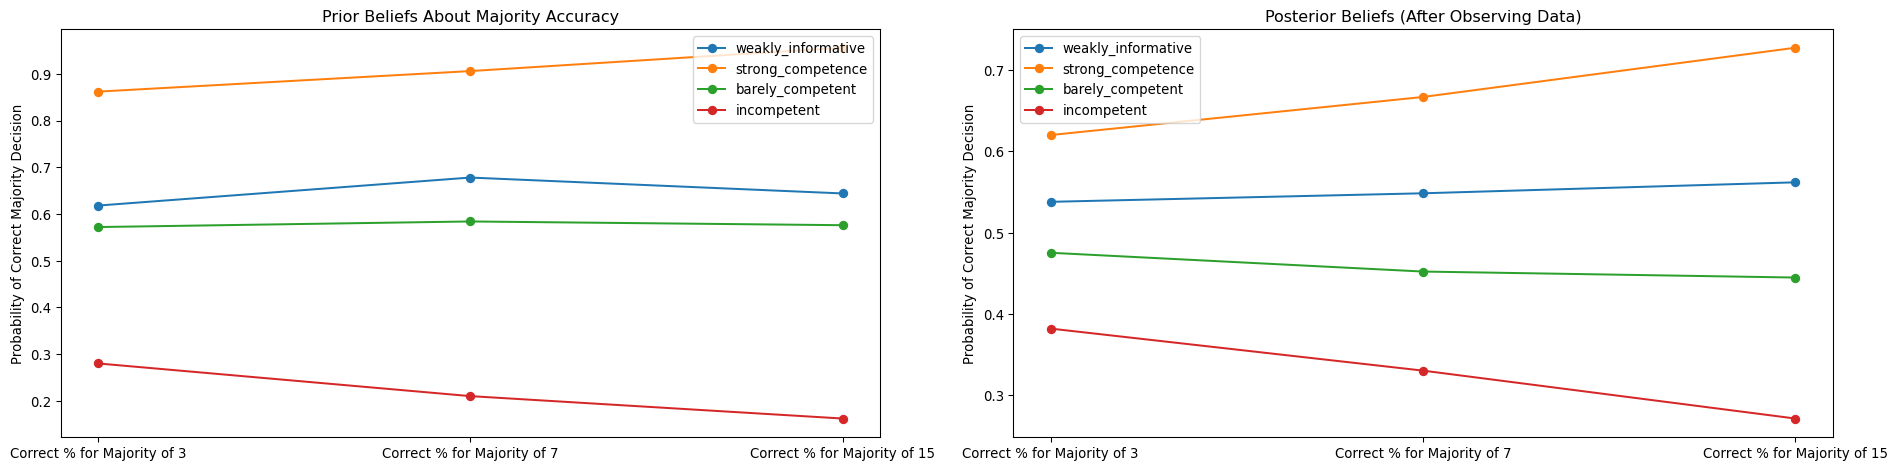

In [7]:
# Visualize the shift from prior to posterior
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

for prior_name in prior_specs.keys():
    axs[0].plot(prior_estimates.index, prior_estimates[prior_name], 
                label=prior_name, marker='o')
    axs[1].plot(posterior_estimates.index, posterior_estimates[prior_name], 
                label=prior_name, marker='o')

axs[0].legend()
axs[1].legend()
axs[0].set_title("Prior Beliefs About Majority Accuracy")
axs[1].set_title("Posterior Beliefs (After Observing Data)")
axs[0].set_ylabel("Probability of Correct Majority Decision")
axs[1].set_ylabel("Probability of Correct Majority Decision")

plt.tight_layout()
plt.show()

You cannot avoid the requirement of minimum competence in the jury pool if you hope for collective wisdom. But more strikingly, when we have even modest competence, the aggregation of votes quickly converges towards high accuracy. This is exactly the finding of Condorcet's Jury Theorem. 

::: {.callout-important}
## Formal Statement: The Condorcet Jury Theorem

Let a group of $n$ independent individuals (a "jury") be tasked with choosing between two outcomes, one of which is "correct." Let $p$ represent the probability of any single individual making the correct choice. The theorem consists of two parts:

1.  **The Competence Requirement:** If $p > 0.5$, then the probability that a majority of the group makes the correct choice is greater than $p$.
2.  **The Asymptotic Result:** As $n \to \infty$, the probability that the majority choice is correct approaches $1$.

Conversely, if $p < 0.5$, increasing the size of the jury only increases the probability that the group will arrive at the *wrong* conclusion, with that probability approaching $1$ as $n$ grows.
:::

This mathematical law is the 'efficiency' that the investor class is buying. You might look at this theorem and see a guarantee: as long as we hire 'competent' people ($p > 0.5$) and align them, we can't lose. But the theorem has a hidden poison pill. It relies entirely on independent errors, and we know that competence isn't uniform. This pulls us in two ways: (1) management panic over hiring standards and (2) fostering diversity in the employee base. We'll look at (1) next. 

## Individual Differences in Competence

The base Condorcet model assumes all jurors are identically competent. In reality, people vary in expertise, attention, and judgment. Let's model **heterogeneity** in juror competence. To gauge these effects we'll use a hierarchical model where individual competencies are drawn from a population distribution. The key sensitivity parameter is $\sigma$ (discrimination): how much do jurors differ?

#### Heterogeneous Juror Competence

We now relax the assumption that all jurors are equally competent. Each juror $j$ is assigned an individual probability of voting correctly:
$$
\text{logit}(p_j) = \mu + \sigma z_j, \qquad z_j \sim \mathcal{N}(0,1).
$$


For a fixed juror $j$, define the number of agreements with the majority:
$$
A_j = \sum_{i=1}^N \mathbb{1}\{V_{ij} = \text{majority}_i\}.
$$

Under the assumption that cases are exchangeable and votes are conditionally independent given $p_j$, we obtain the exact likelihood:

$$
A_j \mid p_j \sim \text{Binomial}(N, p_j).
$$

This is not an approximation. It is the marginal likelihood obtained by integrating over $$N$$ independent Bernoulli trials:
$$
\prod_{i=1}^N \text{Bernoulli}(V_{ij} \mid p_j)
\;\Longrightarrow\;
\text{Binomial}(A_j \mid N, p_j).
$$

This observation motivates a re-articuation of the condorcet model. The binomial phrasing is often easier to sample than the Bernoulli likelihood, so we shall switch to that model. Our next model uses a Binomial likelihood and  relies on two assumptions. We hold fixed the exchangeability across the cases and we rely on sufficiency of the count statistic. Once jurors are treated as stable measurement instruments, their entire voting history becomes a single aggregated observation. 

### Model 2: Varying Competence


In [8]:
def fit_hierarchical_model(votes, n_jurors, discrimination_prior):
    """
    Fit hierarchical model with individual variation in competence.
    
    Model structure:
    - μ: population mean competence (in logit space)
    - σ: population standard deviation (SENSITIVITY PARAMETER)
    - Each juror has individual competence drawn from N(μ, σ)
    
    We use non-centered parameterization for better sampling.
    """
    majority_votes = (votes.mean(axis=1) > 0.5).astype(int)
    agreements_per_juror = np.array([
        (votes[:, j] == majority_votes).sum() for j in range(n_jurors)
    ])
    
    with pm.Model() as model:
        # Population-level parameters
        mu_logit_p = pm.Normal('mu_logit_p', mu=0.6, sigma=0.5)
        
        # KEY SENSITIVITY PARAMETER: individual discrimination
        sigma_logit_p = pm.HalfNormal(
            'sigma_logit_p', 
            sigma=discrimination_prior['sigma']
        )
        
        # Non-centered parameterization: logit_p = μ + σ * z
        z_juror = pm.Normal('z_juror', mu=0, sigma=1, shape=n_jurors)
        logit_p_juror = pm.Deterministic(
            'logit_p_juror', 
            mu_logit_p + sigma_logit_p * z_juror
        )
        p_juror = pm.Deterministic('p_juror', pm.math.invlogit(logit_p_juror))
        
        # Collapsed likelihood: count agreements with majority
        pm.Binomial('agreements', n=N_CASES, p=p_juror, 
                   observed=agreements_per_juror)
        
        idata = pm.sample_prior_predictive()
        idata.extend(pm.sample(1000, tune=2000, random_seed=42,
                              target_accept=0.95, return_inferencedata=True,
                              idata_kwargs={"log_likelihood": True}))
        idata.extend(pm.sample_posterior_predictive(idata))
    
    return idata, model


Again, we'll test a range of priors. But this time we'll push on the range of permissable competence in the jury pool. 


In [9]:
# | output: false

# Test three levels of discrimination
discrimination_priors = {
    'weak_discrimination': {
        'sigma': 0.5, 
        'desc': 'Weak discrimination (σ ~ 0.5)'
    },
    'moderate_discrimination': {
        'sigma': 1.0, 
        'desc': 'Moderate discrimination (σ ~ 1)'
    },
    'strong_discrimination': {
        'sigma': 2.0, 
        'desc': 'Strong discrimination (σ ~ 2)'
    },
}

traces_discrimination = {}
for prior_name, spec in discrimination_priors.items():
    print(f"\nFitting with {spec['desc']}...")
    idata, model = fit_hierarchical_model(votes, N_JURORS, spec)
    traces_discrimination[prior_name] = idata
    traces_discrimination[prior_name + '_model'] = model


Fitting with Weak discrimination (σ ~ 0.5)...


Sampling: [agreements, mu_logit_p, sigma_logit_p, z_juror]


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [mu_logit_p, sigma_logit_p, z_juror]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 2 seconds.


Sampling: [agreements]


Output()

Sampling: [agreements, mu_logit_p, sigma_logit_p, z_juror]


Initializing NUTS using jitter+adapt_diag...



Fitting with Moderate discrimination (σ ~ 1)...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [mu_logit_p, sigma_logit_p, z_juror]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 2 seconds.


Sampling: [agreements]


Output()

Sampling: [agreements, mu_logit_p, sigma_logit_p, z_juror]


Initializing NUTS using jitter+adapt_diag...



Fitting with Strong discrimination (σ ~ 2)...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [mu_logit_p, sigma_logit_p, z_juror]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 2 seconds.


Sampling: [agreements]


Output()

Whereas in the previous model we observed each and every vote in the likelihood, here we're abstracting away from the particular and assuming their realised values are a consequece of latent structure; individual estimable competence. 


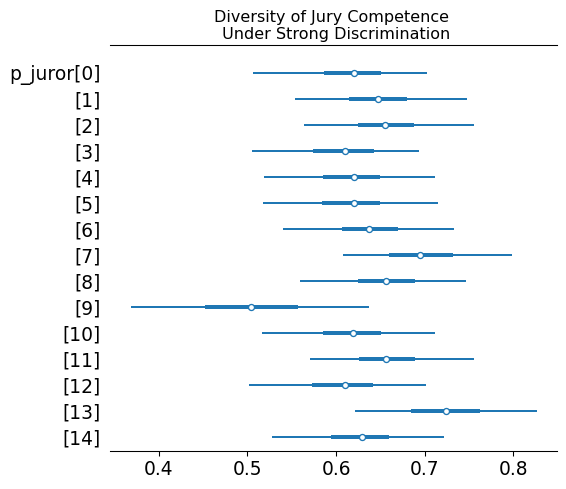

In [10]:
# Examine one of the fitted models
ax = az.plot_forest(traces_discrimination['strong_discrimination'], var_names=['p_juror'], combined=True)
ax[0].set_title("Diversity of Jury Competence \n Under Strong Discrimination");

By collapsing these observations into a Binomial distribution, we focus the model’s attention on the success rate of the collective. Paradoxically, by "throwing away" the individual case observations of the jurors, we force the model to account for the variance in the process itself.

### The Generative Process and Implied Votes 

It's for this reason we now rely on Posterior Predictive Sampling (PPC) to reconstruct these votes is that we are no longer just fitting a line to a set of points; we are simulating a generative process. To understand the implications of different discrimination levels, we need to simulate complete jury deliberations. In other words, we need to translate our individual voter's profile into votes. 
$$
V_{ij} \mid T_i, p_j \sim
\begin{cases}
\text{Bernoulli}(p_j) & \text{if } T_i = 1, \\
\text{Bernoulli}(1-p_j) & \text{if } T_i = 0.
\end{cases}
$$

This will then allow us to test for accuracy of the majority under different ranges of skill. The core insight is that we must forward sample to derive the voting profile of each individual.


In [11]:
def simulate_votes_from_competence(p_juror, n_cases, truth=None):
    """Generate votes given juror competencies and ground truth."""
    n_jurors = len(p_juror)
    if truth is None:
        truth = np.random.binomial(1, 0.5, size=n_cases)
    
    votes = np.zeros((n_cases, n_jurors), dtype=int)
    for i in range(n_cases):
        for j in range(n_jurors):
            prob = p_juror[j] if truth[i] == 1 else 1 - p_juror[j]
            votes[i, j] = np.random.binomial(1, prob)
    
    return truth, votes


To do so we'll define a number of helper functions below.


In [12]:
# | code-fold: true

def compute_diagnostics(votes, truth):
    """Compute suite of diagnostic metrics for jury performance."""
    majority = votes.mean(axis=1) > 0.5
    
    diagnostics = {
        'majority_accuracy': np.mean(majority == truth),
        'unanimity_rate': np.mean(
            (votes.sum(axis=1) == 0) | (votes.sum(axis=1) == votes.shape[1])
        ),
        'juror_agreement': np.mean(votes == truth[:, None], axis=0),
    }
    
    # Error correlation: do jurors make mistakes together?
    errors = votes != truth[:, None]
    if errors.var(axis=0).sum() > 0:
        diagnostics['error_corr'] = np.corrcoef(errors.T)
    else:
        diagnostics['error_corr'] = np.zeros((votes.shape[1], votes.shape[1]))
    
    return diagnostics


def majority_accuracy_by_size(votes, truth, jury_size):
    """Calculate accuracy for random sub-juries of given size."""
    n_cases, n_jurors = votes.shape
    correct = np.zeros(n_cases, dtype=int)
    
    for i in range(n_cases):
        jurors = np.random.choice(n_jurors, size=jury_size, replace=False)
        majority = votes[i, jurors].mean() > 0.5
        correct[i] = (majority == truth[i])
    
    return correct.mean()


def run_ppc_analysis(idata, n_cases, truth, jury_sizes=JURY_SIZES):
    """Run comprehensive posterior predictive checks."""
    p_juror_samples = (idata.posterior['p_juror']
                      .stack(sample=("chain", "draw")).values)
    n_jurors, n_samples = p_juror_samples.shape
    
    results = {
        'majority_acc': np.zeros(n_samples),
        'unanimity': np.zeros(n_samples),
        'error_corr': np.zeros((n_samples, n_jurors, n_jurors)),
        'accuracy_by_size': {k: np.zeros(n_samples) for k in jury_sizes}
    }
    
    for s in range(n_samples):
        _, votes = simulate_votes_from_competence(
            p_juror_samples[:, s], n_cases, truth
        )
        diag = compute_diagnostics(votes, truth)
        
        results['majority_acc'][s] = diag['majority_accuracy']
        results['unanimity'][s] = diag['unanimity_rate']
        results['error_corr'][s] = diag['error_corr']
        
        for k in jury_sizes:
            results['accuracy_by_size'][k][s] = (
                majority_accuracy_by_size(votes, truth, k)
            )
    
    return results


def summarize_ppc(ppc_results, jury_sizes=JURY_SIZES):
    """Create summary DataFrame from PPC results."""
    percentiles = [5, 50, 95]
    summaries = []
    
    for k in jury_sizes:
        summaries.append(np.percentile(
            ppc_results['accuracy_by_size'][k], percentiles
        ))
    
    df = pd.DataFrame(summaries).T
    df.columns = [f'majority_accuracy_{k}' for k in jury_sizes]
    df.index = [f'percentile_{p}' for p in percentiles]
    
    return df


def compare_prior_posterior(idata, n_cases, truth, jury_sizes=JURY_SIZES):
    """Compare prior and posterior predictive distributions."""
    results = {}
    
    for stage in ['prior', 'posterior']:
        p_samples = (getattr(idata, stage)['p_juror']
                    .stack(sample=("chain", "draw")).values)
        n_jurors, n_samples = p_samples.shape
        
        # Simplified PPC for comparison
        stage_results = {k: np.zeros(n_samples) for k in jury_sizes}
        for s in range(n_samples):
            _, votes = simulate_votes_from_competence(
                p_samples[:, s], n_cases, truth
            )
            for k in jury_sizes:
                stage_results[k][s] = majority_accuracy_by_size(votes, truth, k)
        
        results[stage] = summarize_ppc({'accuracy_by_size': stage_results}, 
                                      jury_sizes)
    
    return pd.concat(results, names=['stage', 'percentile'])

def plot_prior_posterior_comparison(df, title="Majority Accuracy"):
    """Plot prior vs posterior distributions."""
    x_values = JURY_SIZES
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for stage, color in [('prior', 'blue'), ('posterior', 'red')]:
        median = df.loc[(stage, 'percentile_50')]
        low = df.loc[(stage, 'percentile_5')]
        high = df.loc[(stage, 'percentile_95')]
        
        ax.plot(x_values, median, label=f'{stage.title()} Median', 
                color=color, marker='o')
        ax.fill_between(x_values, low, high, color=color, alpha=0.2,
                       label=f'{stage.title()} (5th-95th)')
    
    ax.set_title(title)
    ax.set_xlabel('Number of Jurors')
    ax.set_ylabel('Majority Accuracy')
    ax.set_xticks(x_values)
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.6)
    
    plt.tight_layout()
    return fig


Now let's apply this framework. We'll focus on the moderate discrimination case as it's most realistic:


In [13]:
# Analyze the moderate discrimination case
print(f"\n{'='*70}")
print(f"Analysis: {discrimination_priors['moderate_discrimination']['desc']}")
print('='*70)

comparison = compare_prior_posterior(
    traces_discrimination['moderate_discrimination'], 
    N_CASES, 
    true_states
)

comparison


Analysis: Moderate discrimination (σ ~ 1)


majority_accuracy_3  majority_accuracy_5  \
stage     percentile                                                
prior     percentile_5                  0.36                 0.34   
          percentile_50                 0.70                 0.75   
          percentile_95                 0.92                 0.94   
posterior percentile_5                  0.58                 0.62   
          percentile_50                 0.70                 0.74   
          percentile_95                 0.80                 0.84   

                         majority_accuracy_7  majority_accuracy_10  \
stage     percentile                                                 
prior     percentile_5                  0.28                  0.28   
          percentile_50                 0.79                  0.82   
          percentile_95                 0.98                  1.00   
posterior percentile_5                  0.66                  0.70   
          percentile_50                 0.78                  0.82   
          percentile_95                 0.88                  0.90   

                         majority_accuracy_15  
stage     percentile                           
prior     percentile_5                   0.24  
          percentile_50                  0.88  
          percentile_95                  1.00  
posterior percentile_5                   0.74  
          percentile_50                  0.86  
          percentile_95                  0.94

We still see convergen to the truth as we scale up the size of our majority even when we allow heterogeneous levels of skill in the voting population. The median prior and posterior estimates of accuracy are quite close, but we've significantly shrunk the uncertainty in our estimate. 


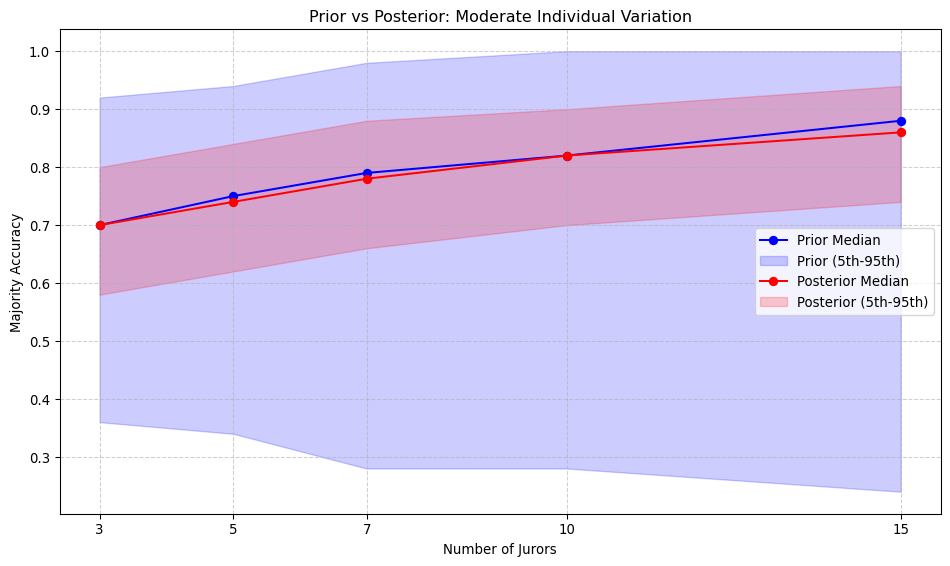

In [14]:
plot_prior_posterior_comparison(
    comparison, 
    title="Prior vs Posterior: Moderate Individual Variation"
);

The pattern is consistent across all discrimination levels: the data updates our beliefs, and larger juries show higher accuracy. The key question is whether errors remain independent.

#### Error Correlation Analysis

A critical assumption of Condorcet is **independence**: jurors make errors independently. Let's check this for our moderate discrimination model:


/Users/nathanielforde/mambaforge/envs/applied-bayesian-regression-modeling-env/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nathanielforde/mambaforge/envs/applied-bayesian-regression-modeling-env/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


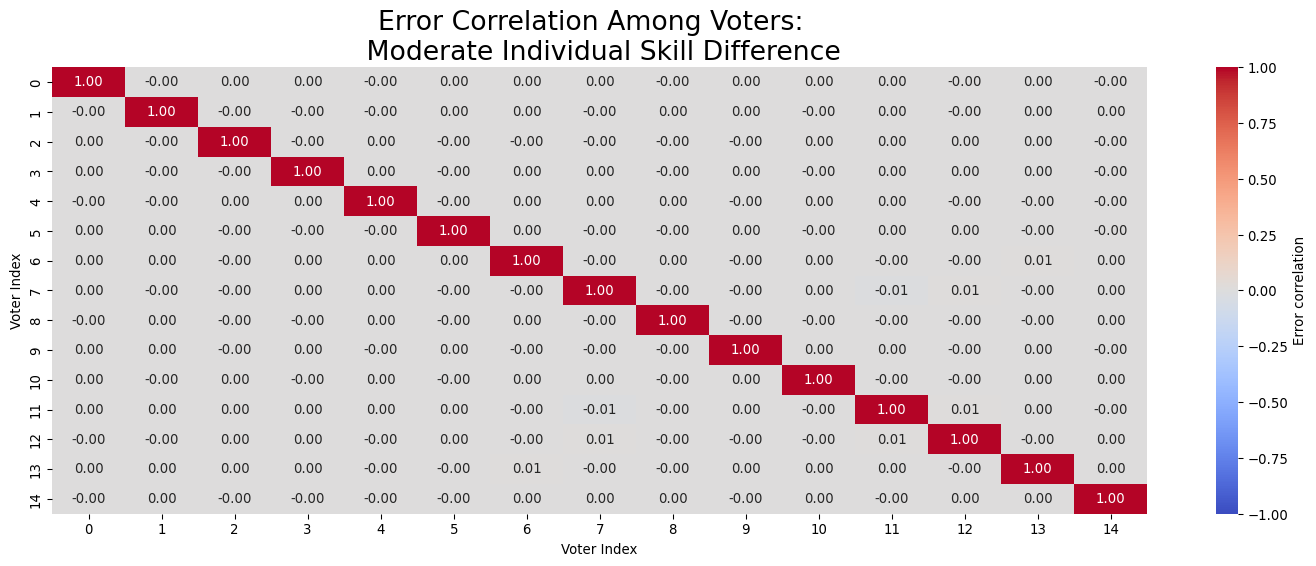

In [15]:
# | output: false
def plot_error_correlation_heatmap(ppc_results, title="Error Correlation"):
    """Plot mean error correlation matrix, handling NaN values properly."""
    all_corrs = ppc_results['error_corr']  # (n_samples, n_jurors, n_jurors)
    
    # Use nanmean to properly average across samples, ignoring NaNs
    mean_corr = np.nanmean(all_corrs, axis=0)
    
    # For cells that are still NaN (all samples were NaN), replace with 0
    mean_corr = np.nan_to_num(mean_corr, nan=0.0)
    mean_corr = np.round(mean_corr, 2)
    fig, ax = plt.subplots(figsize=(15, 6))
    sns.heatmap(mean_corr, vmin=-1, vmax=1, cmap="coolwarm",
                square=False, cbar_kws={"label": "Error correlation"}, ax=ax, 
                annot=True, fmt=".2f")
    ax.set_title(title, fontsize=20)
    ax.set_xlabel("Voter Index")
    ax.set_ylabel("Voter Index")
    plt.tight_layout()
    return fig


def summarize_error_correlation(ppc_results):
    """Extract summary statistics from error correlation matrices."""
    corr = ppc_results['error_corr']
    n = corr.shape[1]
    
    off_diag = []
    for s in range(corr.shape[0]):
        mat = corr[s]
        # Extract upper triangle (excluding diagonal)
        upper_tri = mat[np.triu_indices(n, k=1)]
        # Only include non-NaN values
        valid_values = upper_tri[~np.isnan(upper_tri)]
        if len(valid_values) > 0:
            off_diag.extend(valid_values)
    
    off_diag = np.array(off_diag)
    
    if len(off_diag) == 0:
        return {
            'mean_off_diag': np.nan,
            'sd_off_diag': np.nan,
            'p95_abs_corr': np.nan,
        }
    
    return {
        'mean_off_diag': off_diag.mean(),
        'sd_off_diag': off_diag.std(),
        'p95_abs_corr': np.percentile(np.abs(off_diag), 95),
    }


ppc_moderate = run_ppc_analysis(
    traces_discrimination['moderate_discrimination'], 
    N_CASES, 
    true_states
)

fig = plot_error_correlation_heatmap(
    ppc_moderate, 
    title="Error Correlation Among Voters:  \n Moderate Individual Skill Difference"
);
fig.savefig("Independent_voter_errors_correlation.png")

![](Independent_voter_errors_correlation.png)


In [16]:
print("\nError Correlation Summary:")
summarize_error_correlation(ppc_moderate)


Error Correlation Summary:


{'mean_off_diag': np.float64(4.1269912183272494e-05),
 'sd_off_diag': np.float64(0.14293965923889015),
 'p95_abs_corr': np.float64(0.2792611296287719)}

**Key insight**: With heterogeneous competence alone, errors remain largely uncorrelated. The Condorcet theorem's independence assumption holds—so far. Which is to say that diverse workforces and varying degrees of competence do not inherently short-circuit the firm's ability to learn. 

## Shared Case Difficulty: When Everyone Fails Together
Now we introduce a critical violation: shared case-level effects. Some cases are genuinely harder, causing even competent jurors to fail together. This is the first structural break in the independence assumption—and it reveals why "hard problems" are exponentially harder for groups than the Condorcet theorem predicts.

### The Nature of Difficulty
In our models so far, we've assumed cases are exchangeable—each decision is equally difficult. But reality is messier. Consider:

- The obvious merger: Everyone agrees it's a good fit
- The ambiguous pivot: Market signals are mixed, competitive response is uncertain
- The moonshot bet: Technical feasibility is genuinely unknown

These aren't just decisions with different answers; they're decisions with different signal strength. When the signal is weak—when δᵢ is large in magnitude—even highly competent decision-makers will struggle. More importantly, they'll struggle in the same direction. This is fundamentally different from the heterogeneous competence we modeled earlier. Individual skill differences create uncorrelated noise: some people excel where others fail, and in aggregate, errors cancel out. Case difficulty creates correlated signal loss: when the evidence is weak, everyone's instruments fail simultaneously.

### The Mathematical Structure of Difficulty Shocks

We now introduce case-level difficulty effects:
$$
\delta_i \sim \mathcal{N}(0, \sigma_{\text{case}}).
$$

Votes are generated according to:
$$
\text{logit}\,\Pr(V_{ij} = T_i)
= \alpha_j + \delta_i.
$$

Notice what's happened to our model's architecture. Previously, each juror's vote depended only on their individual competence αⱼ and the truth Tᵢ. Now there's a third term—δᵢ—that affects every juror voting on case i. When δᵢ is large and negative, even our most competent jurors face degraded odds. When it's large and positive, even marginal performers temporarily shine.

### Structural Consequences of Error

Votes for the same case now share a common latent influence.
As a result:
$$
V_{ij} \not\!\perp V_{ik} \mid T_i, \alpha_j.
$$

conditioning on the truth is no longer sufficient to guarantee independence. Two jurors voting on the same hard case will make correlated errors, even if they're drawing on completely different expertise and making independent judgments. The theorem's guarantee—that majority accuracy approaches 100% with large groups—relied on errors being independent and therefore canceling out. But correlated errors don't cancel; they accumulate.

### Simulating Shared Case Shocks
To properly explore this, we need to do posterior predictive sampling that includes case difficulty in the generative model. We can't just fit a model with case effects and examine the posterior—we need to generate new votes under different difficulty regimes and see how the correlation structure changes.


In [17]:
# Simpler approach: directly simulate from posterior samples
def simple_case_difficulty_ppc(idata, n_cases_sim, sigma_case_values, 
                               true_states=None, n_draws=500):
    """
    Simplified PPC that samples logit_p from posterior then adds case effects.
    """
    if true_states is None:
        true_states = np.random.binomial(1, 0.5, size=n_cases_sim)
    
    # Get posterior samples
    logit_p_samples = (idata.posterior['logit_p_juror']
                      .stack(sample=("chain", "draw")).values)
    n_jurors, total_samples = logit_p_samples.shape
    
    # Randomly select n_draws samples
    sample_idx = np.random.choice(total_samples, size=n_draws, replace=False)
    logit_p_samples = logit_p_samples[:, sample_idx]
    
    results = {}
    
    for sigma_case in sigma_case_values:
        votes_array = np.zeros((n_draws, n_cases_sim, n_jurors), dtype=int)
        
        for s in range(n_draws):
            # Sample case difficulty effects
            delta_case = np.random.normal(0, sigma_case, size=n_cases_sim)
            
            for i in range(n_cases_sim):
                truth_i = true_states[i]
                sign = 1 if truth_i == 1 else -1
                
                # Apply case difficulty to all jurors
                logit_p_case = sign * logit_p_samples[:, s] + delta_case[i]
                p_case = 1 / (1 + np.exp(-logit_p_case))
                
                votes_array[s, i, :] = np.random.binomial(1, p_case)
        
        # Calculate diagnostics
        acc = []
        corrs = []
        
        for s in range(n_draws):
            majority = votes_array[s].mean(axis=1) > 0.5
            acc.append((majority == true_states).mean())
            
            errors = votes_array[s] != true_states[:, None]
            if errors.var(axis=0).sum() > 0:
                C = np.corrcoef(errors.T)
                corrs.append(C)
        
        corrs = np.stack(corrs) if corrs else np.zeros((1, n_jurors, n_jurors))
        off_diag = corrs[:, ~np.eye(n_jurors, dtype=bool)]
        
        results[sigma_case] = {
            'accuracy': acc,
            'mean_accuracy': np.mean(acc),
            'error_corr': corrs,
            'mean_corr': np.nanmean(off_diag),
            'median_corr': np.nanmedian(off_diag),
            'p95_abs_corr': np.nanpercentile(np.abs(off_diag), 95)
        }
    
    return results


print("="*70)
print("IMPACT OF SHARED CASE DIFFICULTY")
print("="*70)

sigma_values = [0.0, 0.2, 0.5, 1.0]
case_diff_results = simple_case_difficulty_ppc(
    traces_discrimination['weak_discrimination'],
    n_cases_sim=N_CASES,
    sigma_case_values=sigma_values,
    true_states=true_states,
    n_draws=500
)

for sigma in sigma_values:
    res = case_diff_results[sigma]
    print(f"\nσ_case = {sigma}")
    print(f"  Mean majority accuracy: {res['mean_accuracy']:.3f}")
    print(f"  Mean error correlation: {res['mean_corr']:.3f}")
    print(f"  Median error correlation: {res['median_corr']:.3f}")
    print(f"  95th %ile |correlation|: {res['p95_abs_corr']:.3f}")

IMPACT OF SHARED CASE DIFFICULTY



σ_case = 0.0
  Mean majority accuracy: 0.853
  Mean error correlation: 0.001
  Median error correlation: 0.000
  95th %ile |correlation|: 0.280

σ_case = 0.2
  Mean majority accuracy: 0.837
  Mean error correlation: 0.010
  Median error correlation: 0.010
  95th %ile |correlation|: 0.281

σ_case = 0.5
  Mean majority accuracy: 0.779
  Mean error correlation: 0.052
  Median error correlation: 0.051
  95th %ile |correlation|: 0.301

σ_case = 1.0
  Mean majority accuracy: 0.687
  Mean error correlation: 0.169
  Median error correlation: 0.169
  95th %ile |correlation|: 0.402


**Critical insight**: As case difficulty variance increases ($\sigma_{case}$), error correlation rises dramatically. At $\sigma_{case} = 1.0$, jurors make correlated errors with mean correlation around 0.15-0.17. This violates the independence assumption and **degrades majority accuracy** even with competent jurors.

The remaining question for organisational design: Are the patterns of correlation among jurors based on independent sources, or do they interact? We'll see that block effects and case difficulty can create a toxic synergy—when hard cases hit groups with shared biases, the correlation compounds and majority rule fails catastrophically. But what can we do about it?

## The Complete Model: Voting Blocks and Improvement Programmes

Now we introduce the forces that will determine whether an organization can sustain collective wisdom or succumbs to coordinated failure: block effects ($\beta$) and treatment programmes ($\tau$). These structural additions represent opposing gravitational forces in a delicate equilibrium. Pull too hard in one direction and you get chaos; pull too hard in the other and you get lockstep failure.

### The Anatomy of Blocks: Epistemic Consolidation
In real organizations, people don't arrive at decisions in isolation. They cluster into groups that share:

- Functional training: All the engineers learned the same architecture patterns; all the MBAs learned the same strategy frameworks
- Information access: The sales team sees customer feedback the finance team never sees; executives receive filtered summaries while front-line workers see raw reality
- Incentive structures: Different departments optimize for different metrics, creating systematically different biases
- Social networks: People who talk to each other regularly start thinking alike, even without realizing it

These patterns promote an consolidation of epistemological standards. Members of a block don't just share surface characteristics; they share ways of knowing and hence ways of being wrong. We saw that case difficulty created correlation across the entire jury for specific cases. But block effects create persistent correlation within subgroups across all cases. This is structurally worse. And then when evidence is ambiguous and cases difficult, people fall back on their frameworks, and if everyone shares frameworks, everyone fails together. The case-difficulty and group-think interact to drive an organisation to shared evaluation of empirical questions.

### The Legibility Trap Redux
Recall that investors demand "alignment" and "standardization". They want unified KPI systems, "Culture fit"-hiring and best-practices adoption, Common Tooling. These forces push us towards organisations towards consolidation of shared incentives, methods and cognitive practices. In Thi Nguygen's work this creates the risk of value capture. Not only can corporate values supplant your individual perspective, they do so at scale. Every legibility-seeking practice is a block-creating mechanism. By making the organization more "readable" to outsiders, you create the very correlations that break collective intelligence.

### The Treatment Paradox
Organisations aren't static. Leaders intervene. They can run training programs, hire consultants, promote new processes, suggest or mandate resolution frameworks. The constant question is whether these interventions break group-think or reinforce it? One useful example is the pattern of "red-teaming" in software development. Before a major decision, you randomly assign people from each block to argue against their block's default position. This intervention creates divergent pressure. It doesn't eliminate block membership. Engineers remain engineers, but it forces block members to engage with perspectives that directly challenge their shared frameworks. The treatment pulls against block effects.

### Adding Group-Level (Block) Effects and Treatment Programmes


In the mathematical formulation we allow that each juror belongs to a block $b(j)$, with:
$$
\beta_{b(j)} \sim \mathcal{N}(0, \sigma_{\text{block}}).
$$

The full voting model becomes:
$$
\text{logit}\,\Pr(V_{ij} = T_i)
= \alpha_j + \beta_{b(j)} + \delta_i - \text{ treatment }*\tau
$$

We can allow for different types of treatment. Global or individual or randomly assinged. The hope is that the treatment mechanism pulls against the push for homogeniety. We generate new data with explict block effects and specify a switch to test the impact of our treatment programme.


In [18]:
# | output: false
# Generate new data with block structure
votes_blocked, p_jurors_blocked, true_states_blocked = simulate_jury_data(
    N_CASES, N_JURORS, block_id=BLOCK_ID
)

def fit_full_model(votes, n_jurors, block_id, treatment_indicator,
    use_treatment=0):
    """
    Complete model with four sources of variation:
    1. Individual skill (α_j)
    2. Block/faction effects (β_block)
    3. Case difficulty (δ_case)
    4. Treatment Programme (tau)
    """
    majority_votes = (votes.mean(axis=1) > 0.5).astype(int)
    agreements_per_juror = np.array([
        (votes[:, j] == majority_votes).sum() for j in range(n_jurors)
    ])
    
    with pm.Model() as model:
        # Individual skill
        mu_alpha = pm.Normal("mu_alpha", mu=0.0, sigma=0.5)
        sigma_alpha = pm.Exponential("sigma_alpha", lam=3.0)
        alpha_raw = pm.Normal("alpha_raw", 0.0, 1.0, shape=n_jurors)
        alpha_j = pm.Normal(
        "alpha_j",
        mu=mu_alpha,
        sigma=sigma_alpha,
        shape=n_jurors,
        )
        
        # Block effects (ideological factions, info silos)
        n_blocks = len(np.unique(block_id))
        sigma_block = pm.HalfNormal("sigma_block", sigma=1.0)
        block_effect = pm.Normal("block_effect", mu=0.0, sigma=sigma_block, shape=n_blocks)
        beta_block_j = block_effect[block_id]
        
        # Case difficulty (collapsed over cases)
        mu_case = pm.Normal("mu_case", mu=0.0, sigma=0.5)
        sigma_case = pm.HalfNormal("sigma_case", sigma=1.0)
        delta_bar = pm.Normal("delta_bar", mu=mu_case, 
                             sigma=sigma_case / pm.math.sqrt(N_CASES))

        # -----------------------------
        # Treatment effect (switchable)
        # -----------------------------
        tau = pm.Exponential("tau", 1.0, shape=N_JURORS)

        # convert to tensors to avoid shape surprises
        Z = pm.math.constant(treatment_indicator)
        s = pm.math.constant(use_treatment)

        treatment_term = pm.Deterministic('trt', s * Z * tau)
        
        # Combined model
        logit_p_correct = ((alpha_j + beta_block_j + delta_bar) - treatment_term)
        p_correct = pm.Deterministic("p_correct", 
                                    pm.math.sigmoid(logit_p_correct))
        
        # Collapsed likelihood
        pm.Binomial("agreements", n=N_CASES, p=p_correct, 
                   observed=agreements_per_juror)
        
        idata = pm.sample(2000, tune=2000, target_accept=0.985, 
                         return_inferencedata=True, nuts_sampler='numpyro')
    
    return idata, model


print("\nFitting complete hierarchical model...")
idata_full, model_full = fit_full_model(votes_blocked, N_JURORS, BLOCK_ID,  treatment_indicator=np.zeros(N_JURORS), use_treatment=0)

idata_full_trt, model_full_trt = fit_full_model(votes_blocked, N_JURORS, BLOCK_ID,  treatment_indicator=np.ones(N_JURORS), use_treatment=1)


Fitting complete hierarchical model...


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

There were 616 divergences after tuning. Increase `target_accept` or reparameterize.


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

There were 160 divergences after tuning. Increase `target_accept` or reparameterize.


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [19]:
print("\n" + "="*70)
print("COMPLETE MODEL SUMMARY")
print("="*70)
full_summary = az.summary(idata_full, var_names=["mu_alpha", "sigma_alpha", "sigma_block", "mu_case", "sigma_case", "trt"])

full_trt_summary = az.summary(idata_full_trt, var_names=["mu_alpha", "sigma_alpha", "sigma_block", "mu_case", "sigma_case", "trt"])

summaries = pd.concat({'Full Model': full_summary, 'Full Model + Treatment': full_trt_summary})
summaries


COMPLETE MODEL SUMMARY


/Users/nathanielforde/mambaforge/envs/applied-bayesian-regression-modeling-env/lib/python3.13/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/nathanielforde/mambaforge/envs/applied-bayesian-regression-modeling-env/lib/python3.13/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
Full Model             mu_alpha     0.288  0.433  -0.501    1.082      0.022   
                       sigma_alpha  0.161  0.128   0.009    0.389      0.010   
                       sigma_block  1.002  0.426   0.360    1.759      0.024   
                       mu_case      0.299  0.418  -0.537    1.048      0.009   
                       sigma_case   0.830  0.621   0.024    1.944      0.025   
                       trt[0]       0.000  0.000   0.000    0.000      0.000   
                       trt[1]       0.000  0.000   0.000    0.000      0.000   
                       trt[2]       0.000  0.000   0.000    0.000      0.000   
                       trt[3]       0.000  0.000   0.000    0.000      0.000   
                       trt[4]       0.000  0.000   0.000    0.000      0.000   
                       trt[5]       0.000  0.000   0.000    0.000      0.000   
                       trt[6]       0.000  0.000   0.000    0.000      0.000   
                       trt[7]       0.000  0.000   0.000    0.000      0.000   
                       trt[8]       0.000  0.000   0.000    0.000      0.000   
                       trt[9]       0.000  0.000   0.000    0.000      0.000   
                       trt[10]      0.000  0.000   0.000    0.000      0.000   
                       trt[11]      0.000  0.000   0.000    0.000      0.000   
                       trt[12]      0.000  0.000   0.000    0.000      0.000   
                       trt[13]      0.000  0.000   0.000    0.000      0.000   
                       trt[14]      0.000  0.000   0.000    0.000      0.000   
Full Model + Treatment mu_alpha     0.417  0.435  -0.423    1.200      0.015   
                       sigma_alpha  0.201  0.158   0.004    0.486      0.010   
                       sigma_block  1.203  0.484   0.419    2.111      0.009   
                       mu_case      0.440  0.453  -0.376    1.326      0.009   
                       sigma_case   0.838  0.604   0.008    1.933      0.009   
                       trt[0]       0.996  0.546   0.016    1.915      0.008   
                       trt[1]       0.525  0.416   0.000    1.275      0.006   
                       trt[2]       1.127  0.572   0.043    2.082      0.010   
                       trt[3]       0.753  0.498   0.001    1.616      0.007   
                       trt[4]       0.213  0.205   0.000    0.589      0.002   
                       trt[5]       0.626  0.388   0.000    1.281      0.006   
                       trt[6]       0.626  0.381   0.004    1.268      0.005   
                       trt[7]       0.365  0.298   0.000    0.904      0.004   
                       trt[8]       0.754  0.405   0.001    1.425      0.006   
                       trt[9]       0.409  0.312   0.001    0.965      0.004   
                       trt[10]      0.457  0.329   0.001    1.029      0.005   
                       trt[11]      0.361  0.303   0.000    0.913      0.004   
                       trt[12]      0.633  0.417   0.000    1.352      0.006   
                       trt[13]      0.511  0.373   0.000    1.180      0.005   
                       trt[14]      0.699  0.421   0.003    1.409      0.006   

                                    mcse_sd  ess_bulk  ess_tail  r_hat  
Full Model             mu_alpha       0.010     396.0    1222.0   1.02  
                       sigma_alpha    0.004      93.0      62.0   1.04  
                       sigma_block    0.007     310.0    5067.0   1.01  
                       mu_case        0.008    2347.0    3868.0   1.02  
                       sigma_case     0.010     674.0    2145.0   1.01  
                       trt[0]           NaN    8000.0    8000.0    NaN  
                       trt[1]           NaN    8000.0    8000.0    NaN  
                       trt[2]           NaN    8000.0    8000.0    NaN  
                       trt[3]           NaN    8000.0    8000.0    NaN  
                       trt

## Posterior Predictive Checks for Complete Model

Now let's examine how the complete model performs, including its error correlations:


In [20]:
def run_ppc_full_model(idata, n_cases, true_states, block_id, 
                       jury_sizes=JURY_SIZES, n_draws=500):
    """
    PPC for complete model including block and case effects.
    Properly samples from posterior distribution.
    """
    # Extract posterior samples
    alpha_j = idata.posterior['alpha_j'].stack(sample=("chain", "draw")).values
    block_effect = idata.posterior['block_effect'].stack(sample=("chain", "draw")).values
    sigma_case = idata.posterior['sigma_case'].stack(sample=("chain", "draw")).values
    mu_case = idata.posterior['mu_case'].stack(sample=("chain", "draw")).values
    trt = idata.posterior['trt'].stack(sample=("chain", "draw")).values
    
    n_jurors = alpha_j.shape[0]
    total_samples = alpha_j.shape[1]
    
    # Randomly select n_draws samples
    sample_idx = np.random.choice(total_samples, size=min(n_draws, total_samples), 
                                 replace=False)
    n_draws = len(sample_idx)
    
    results = {
        'majority_acc': np.zeros(n_draws),
        'error_corr': np.zeros((n_draws, n_jurors, n_jurors)),
        'accuracy_by_size': {k: np.zeros(n_draws) for k in jury_sizes}
    }
    
    rng = np.random.default_rng(42)
    
    for idx, s in enumerate(sample_idx):
        # Sample case difficulty effects for this posterior draw
        delta_case = rng.normal(mu_case[s], sigma_case[s], size=n_cases)
        
        # Generate votes for each case
        votes = np.zeros((n_cases, n_jurors), dtype=int)
        
        for i in range(n_cases):
            truth_i = true_states[i]
            sign = 1 if truth_i == 1 else -1
            
            for j in range(n_jurors):
                # Combine individual skill + block effect + case difficulty
                logit_p = sign * (alpha_j[j, s] + block_effect[block_id[j], s]) + delta_case[i] + trt[j, s]
                p = 1 / (1 + np.exp(-logit_p))
                votes[i, j] = rng.binomial(1, p)
        
        # Compute diagnostics
        diag = compute_diagnostics(votes, true_states)
        results['majority_acc'][idx] = diag['majority_accuracy']
        results['error_corr'][idx] = diag['error_corr']
        
        for k in jury_sizes:
            results['accuracy_by_size'][k][idx] = (
                majority_accuracy_by_size(votes, true_states, k)
            )
    
    return results


print("\nRunning posterior predictive checks for complete model...")
ppc_full = run_ppc_full_model(idata_full, N_CASES, true_states_blocked, 
                               BLOCK_ID, n_draws=500)

ppc_full_trt = run_ppc_full_model(idata_full_trt, N_CASES, true_states_blocked, 
                               BLOCK_ID, n_draws=500)

# Summarize accuracy by jury size
summary_full = summarize_ppc(ppc_full)
print("\n" + "="*70)
print("MAJORITY ACCURACY BY JURY SIZE (Complete Model)")
print("="*70)
print(summary_full)


Running posterior predictive checks for complete model...


/Users/nathanielforde/mambaforge/envs/applied-bayesian-regression-modeling-env/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nathanielforde/mambaforge/envs/applied-bayesian-regression-modeling-env/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


/Users/nathanielforde/mambaforge/envs/applied-bayesian-regression-modeling-env/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nathanielforde/mambaforge/envs/applied-bayesian-regression-modeling-env/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]



MAJORITY ACCURACY BY JURY SIZE (Complete Model)
               majority_accuracy_3  majority_accuracy_5  majority_accuracy_7  \
percentile_5                  0.48                 0.48                0.500   
percentile_50                 0.66                 0.70                0.700   
percentile_95                 0.84                 0.88                0.901   

               majority_accuracy_10  majority_accuracy_15  
percentile_5                   0.46                  0.48  
percentile_50                  0.72                  0.74  
percentile_95                  0.92                  0.96  


Notice how the increasing size of the voting block does not substantially improve on the accuracy. This pattern is also unfortunately visible in our treatment model. 


In [21]:
summary_full_trt = summarize_ppc(ppc_full_trt)
print("\n" + "="*70)
print("MAJORITY ACCURACY BY JURY SIZE (Complete Model + Treatment)")
print("="*70)
print(summary_full_trt)



MAJORITY ACCURACY BY JURY SIZE (Complete Model + Treatment)
               majority_accuracy_3  majority_accuracy_5  majority_accuracy_7  \
percentile_5                  0.56                 0.56                 0.56   
percentile_50                 0.72                 0.74                 0.76   
percentile_95                 0.92                 0.96                 0.98   

               majority_accuracy_10  majority_accuracy_15  
percentile_5                   0.56                  0.58  
percentile_50                  0.78                  0.76  
percentile_95                  0.98                  1.00  


The allocation of a heterogenous treatment progromme was not sufficient to break the block voting effects. The increased correlations between voters reduces the number of independent signals in the jury pool. 



ERROR CORRELATION SUMMARY (Complete Model)
mean_off_diag: 0.158
sd_off_diag: 0.186
p95_abs_corr: 0.477


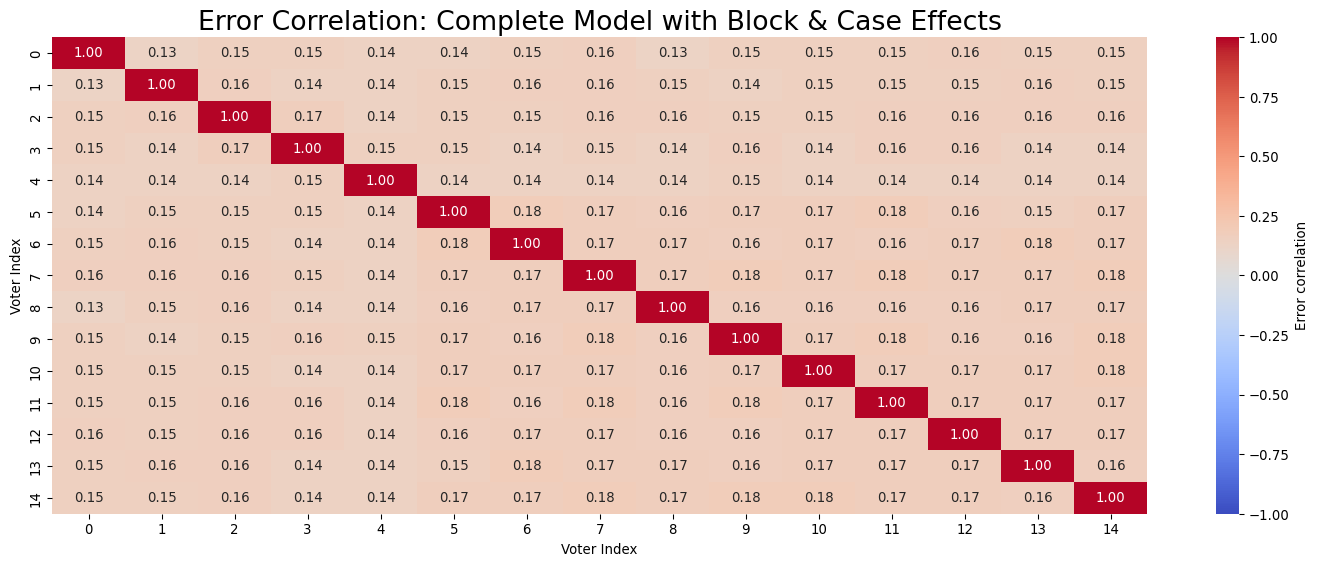

In [22]:
# Plot error correlations
plot_error_correlation_heatmap(
    ppc_full,
    title="Error Correlation: Complete Model with Block & Case Effects"
)

print("\n" + "="*70)
print("ERROR CORRELATION SUMMARY (Complete Model)")
print("="*70)
error_summary = summarize_error_correlation(ppc_full)
for key, value in error_summary.items():
    print(f"{key}: {value:.3f}")

Notice the structured patterns in the error correlation heatmap—jurors within the same block (0-4, 5-10, 11-14) show correlated errors. This is the smoking gun: **block effects create dependencies that violate the independence assumption**.



ERROR CORRELATION SUMMARY (Complete Model)
mean_off_diag: 0.244
sd_off_diag: 0.204
p95_abs_corr: 0.578


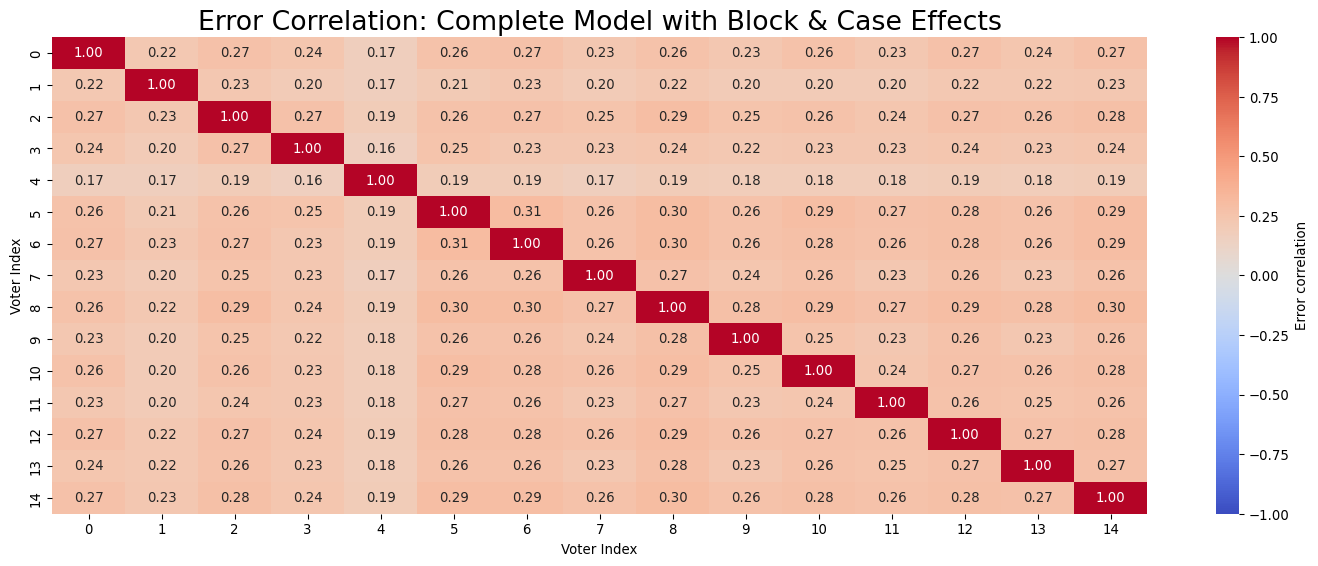

In [23]:
# Plot error correlations
plot_error_correlation_heatmap(
    ppc_full_trt,
    title="Error Correlation: Complete Model with Block & Case Effects"
)

print("\n" + "="*70)
print("ERROR CORRELATION SUMMARY (Complete Model)")
print("="*70)
error_summary = summarize_error_correlation(ppc_full_trt)
for key, value in error_summary.items():
    print(f"{key}: {value:.3f}")

While the correlation patterns change slightly, they remain high and reduce the effectiveness of the majority.

Let's visualize how much this matters:

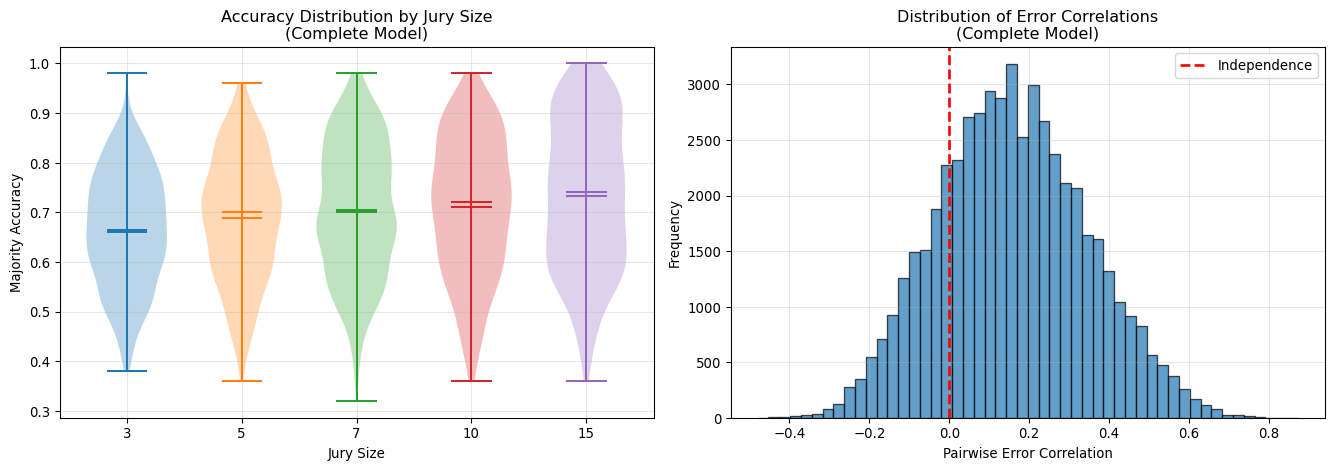


QUANTIFYING THE VIOLATION
Mean error correlation: nan
Proportion of positive correlations: 79.2%

Median accuracy (15 jurors): 0.740
Median accuracy (3 jurors): 0.660
Improvement from larger jury: 0.080


In [24]:
#| code-fold: true 
#| 
def final_plot(ppc_full):
    # Compare accuracy distributions
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Plot 1: Accuracy by jury size
    ax = axes[0]
    jury_size_labels = [3, 5, 7, 10, 15]
    for i, size in enumerate(jury_size_labels):
        accuracies = ppc_full['accuracy_by_size'][size]
        ax.violinplot([accuracies], positions=[i], widths=0.7, 
                    showmeans=True, showmedians=True)

    ax.set_xticks(range(len(jury_size_labels)))
    ax.set_xticklabels(jury_size_labels)
    ax.set_xlabel('Jury Size')
    ax.set_ylabel('Majority Accuracy')
    ax.set_title('Accuracy Distribution by Jury Size\n(Complete Model)')
    ax.grid(True, alpha=0.3)

    # Plot 2: Error correlation distribution
    ax = axes[1]
    off_diag_corrs = []
    for s in range(ppc_full['error_corr'].shape[0]):
        mat = ppc_full['error_corr'][s]
        n = mat.shape[0]
        off_diag_corrs.extend(mat[np.triu_indices(n, k=1)])

    ax.hist(off_diag_corrs, bins=50, alpha=0.7, edgecolor='black')
    ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Independence')
    ax.set_xlabel('Pairwise Error Correlation')
    ax.set_ylabel('Frequency')
    ax.set_title('Distribution of Error Correlations\n(Complete Model)')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Calculate the impact on the Condorcet theorem
    print("\n" + "="*70)
    print("QUANTIFYING THE VIOLATION")
    print("="*70)
    print(f"Mean error correlation: {np.mean(off_diag_corrs):.3f}")
    print(f"Proportion of positive correlations: {(np.array(off_diag_corrs) > 0).mean():.1%}")
    print(f"\nMedian accuracy (15 jurors): {np.median(ppc_full['accuracy_by_size'][15]):.3f}")
    print(f"Median accuracy (3 jurors): {np.median(ppc_full['accuracy_by_size'][3]):.3f}")
    print(f"Improvement from larger jury: {np.median(ppc_full['accuracy_by_size'][15]) - np.median(ppc_full['accuracy_by_size'][3]):.3f}")


final_plot(ppc_full)

Similar final patterns can be seen again with the treatment model.


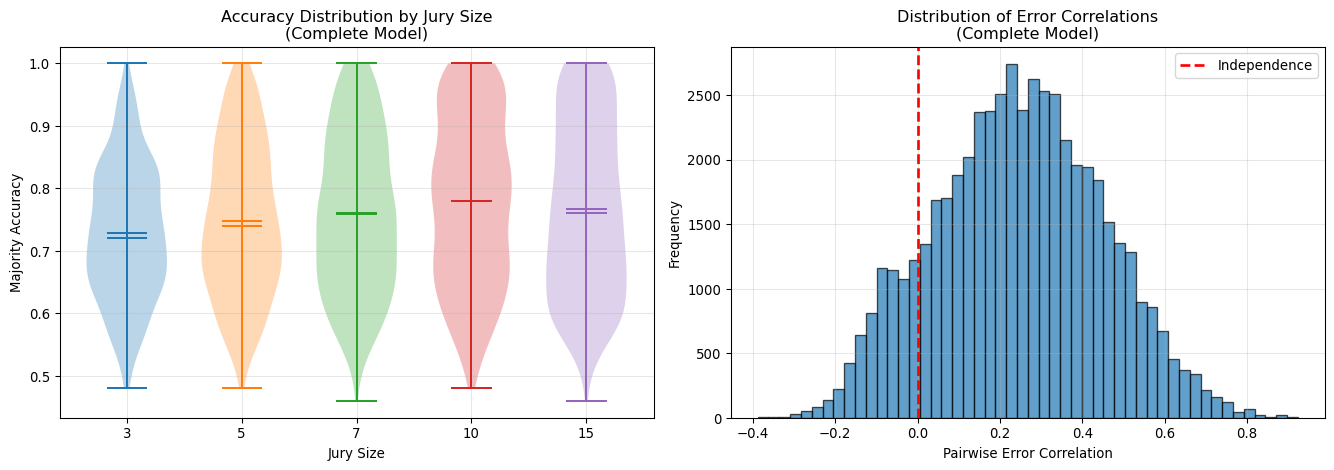


QUANTIFYING THE VIOLATION
Mean error correlation: nan
Proportion of positive correlations: 86.1%

Median accuracy (15 jurors): 0.760
Median accuracy (3 jurors): 0.720
Improvement from larger jury: 0.040


In [25]:
final_plot(ppc_full_trt)

# Conclusions

Through systematic sensitivity analysis, we've identified three critical failure modes for democratic aggregation:

1. **Heterogeneous Competence**: Individual differences alone don't break the Condorcet theorem, but they do create inequality in influence. A few highly competent jurors can dominate.

2. **Shared Difficulties**: When cases vary in difficulty—especially systematically—jurors make correlated errors. This is the most severe violation: it directly undermines the statistical power of aggregation.

3. **Group Effects**: Ideological factions, information silos, and social clustering create structured dependence. Jurors no longer provide independent evidence.

The Condorcet Jury Theorem remains a powerful ideal, but its assumptions are fragile. Real-world collective decision-making must account for:
- Training and expertise development (reduce heterogeneity)
- Procedural safeguards against groupthink (break dependencies)
- Recognition of case difficulty (adjust decision rules)
- Diverse information sources (counteract block effects)

Democracy works—but only when we actively work to satisfy its preconditions.